        imports

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from numpy import array
import yfinance as yf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



        Extraction de données

In [22]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

def fetch_crypto_data_in_chunks(ticker, interval, total_days, chunk_days=8):

    end_date = datetime.utcnow()
    start_date = end_date - timedelta(days=total_days)
    combined_data = pd.DataFrame()

    while end_date > start_date:
        chunk_start = end_date - timedelta(days=chunk_days)
        if chunk_start < start_date:  
            chunk_start = start_date

        print(f"Fetching data from {chunk_start} to {end_date}")

     
        data = yf.download(
            tickers=ticker,
            interval=interval,
            start=chunk_start.strftime("%Y-%m-%d"),
            end=end_date.strftime("%Y-%m-%d")
        )

        # Append chunk data to the combined DataFrame
        if not data.empty:
            combined_data = pd.concat([data, combined_data])
        else:
            print(f"No data fetched for the period {chunk_start} to {end_date}")

        # Move the end_date back by chunk_days
        end_date = chunk_start
        # Rename columns for better readability
    combined_data.columns = [
        'Adj_Close', 'Close', 'High', 'Low', 'Open', 'Volume'
    ]

    return combined_data



In [23]:
# Fetch 3 months of 1-hour data for Bitcoin
ticker = "BTC-USD"
interval = "1h"
total_days = 90
chunk_days = 8

btc_data = fetch_crypto_data_in_chunks(ticker, interval, total_days, chunk_days)

Fetching data from 2024-12-11 16:56:03.841986 to 2024-12-19 16:56:03.841986


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Fetching data from 2024-12-03 16:56:03.841986 to 2024-12-11 16:56:03.841986
Fetching data from 2024-11-25 16:56:03.841986 to 2024-12-03 16:56:03.841986



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Fetching data from 2024-11-17 16:56:03.841986 to 2024-11-25 16:56:03.841986



[*********************100%***********************]  1 of 1 completed


Fetching data from 2024-11-09 16:56:03.841986 to 2024-11-17 16:56:03.841986
Fetching data from 2024-11-01 16:56:03.841986 to 2024-11-09 16:56:03.841986


[*********************100%***********************]  1 of 1 completed


Fetching data from 2024-10-24 16:56:03.841986 to 2024-11-01 16:56:03.841986


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching data from 2024-10-16 16:56:03.841986 to 2024-10-24 16:56:03.841986
Fetching data from 2024-10-08 16:56:03.841986 to 2024-10-16 16:56:03.841986


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching data from 2024-09-30 16:56:03.841986 to 2024-10-08 16:56:03.841986
Fetching data from 2024-09-22 16:56:03.841986 to 2024-09-30 16:56:03.841986


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Fetching data from 2024-09-20 16:56:03.841986 to 2024-09-22 16:56:03.841986


In [24]:
btc_data

,Adj_Close,Close,High,Low,Open,Volume
Datetime,,,,,,
2024-09-20 00:00:00+00:00,62800.246094,62800.246094,63020.199219,62721.148438,62958.390625,0
2024-09-20 01:00:00+00:00,63006.792969,63006.792969,63139.859375,62636.746094,62773.257812,0
2024-09-20 02:00:00+00:00,63099.804688,63099.804688,63108.054688,62827.015625,63045.738281,0
2024-09-20 03:00:00+00:00,63607.882812,63607.882812,63644.164062,63092.574219,63123.074219,460214272
2024-09-20 04:00:00+00:00,63837.421875,63837.421875,64059.882812,63751.574219,63751.574219,2171752448
...,...,...,...,...,...,...
2024-12-18 19:00:00+00:00,102911.773438,102911.773438,104614.578125,102911.773438,104604.976562,3314745344
2024-12-18 20:00:00+00:00,100943.164062,100943.164062,102757.773438,100281.554688,102733.023438,12143747072
2024-12-18 21:00:00+00:00,101174.335938,101174.335938,101601.015625,100473.093750,100753.351562,4499177472


In [25]:
import pandas as pd

btc_data.reset_index(inplace=True)
btc_data.columns = ['Datetime', 'Adj_Close', 'Close', 'High', 'Low', 'Open', 'Volume']


In [26]:
btc_data.head()

,Datetime,Adj_Close,Close,High,Low,Open,Volume
0,2024-09-20 00:00:00+00:00,62800.246094,62800.246094,63020.199219,62721.148438,62958.390625,0
1,2024-09-20 01:00:00+00:00,63006.792969,63006.792969,63139.859375,62636.746094,62773.257812,0
2,2024-09-20 02:00:00+00:00,63099.804688,63099.804688,63108.054688,62827.015625,63045.738281,0
3,2024-09-20 03:00:00+00:00,63607.882812,63607.882812,63644.164062,63092.574219,63123.074219,460214272
4,2024-09-20 04:00:00+00:00,63837.421875,63837.421875,64059.882812,63751.574219,63751.574219,2171752448


In [27]:
btc_data.to_csv('btc_price_hourly.csv')

        Transformation de données

In [28]:
import pandas as pd

# Assuming 'data' is your pandas DataFrame with columns including 'Close'
def calculate_statistics_df(df):
    
    df['Datetime'] = pd.to_datetime(df['Datetime'])

    # Group by 'Date' (extracted from 'Datetime')
    daily_stats = df.groupby(df['Datetime'].dt.date)['Close'].agg(['min', 'max', 'median', 'mean']).reset_index()

    # Rename columns for clarity
    daily_stats.columns = ['Date', 'Min Close', 'Max Close', 'Median Close', 'Average Close']
    
    return daily_stats




In [29]:
# Example usage with your DataFrame 'btc_data'
stats_df = calculate_statistics_df(btc_data)
stats_df.head(5)

,Date,Min Close,Max Close,Median Close,Average Close
0,2024-09-20,62695.214844,63837.421875,63177.144531,63236.537272
1,2024-09-21,62864.562500,63389.632812,63141.125000,63113.887533
2,2024-09-22,62629.886719,63964.015625,62960.189453,63005.569173
3,2024-09-23,63183.527344,64349.203125,63482.707031,63533.783854
4,2024-09-24,62966.464844,64629.113281,63496.111328,63564.562012


        Persistence de données

In [30]:
stats_df.to_csv('daily_btc_price.csv')


        Téléchargement de données

In [2]:
file_path = 'btc_price_hourly.csv'
btc_data = pd.read_csv(file_path)

btc_data.head(), btc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2160 non-null   int64  
 1   Datetime    2160 non-null   object 
 2   Adj_Close   2160 non-null   float64
 3   Close       2160 non-null   float64
 4   High        2160 non-null   float64
 5   Low         2160 non-null   float64
 6   Open        2160 non-null   float64
 7   Volume      2160 non-null   int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 135.1+ KB


(   Unnamed: 0                   Datetime     Adj_Close         Close  \
 0           0  2024-09-13 00:00:00+00:00  58032.652344  58032.652344   
 1           1  2024-09-13 01:00:00+00:00  58116.558594  58116.558594   
 2           2  2024-09-13 02:00:00+00:00  58054.320312  58054.320312   
 3           3  2024-09-13 03:00:00+00:00  57850.914062  57850.914062   
 4           4  2024-09-13 04:00:00+00:00  57856.675781  57856.675781   
 
            High           Low          Open  Volume  
 0  58226.265625  58027.382812  58129.222656       0  
 1  58183.027344  57897.503906  58034.039062       0  
 2  58160.027344  58016.046875  58122.242188       0  
 3  58069.199219  57850.914062  58046.656250       0  
 4  57982.593750  57852.460938  57852.460938       0  ,
 None)

- Le jeu de données contient 2160 enregistrements horaires couvrant 90 jours, avec les colonnes suivantes :

        - Datetime : Horodatages pour les prix horaires.
        - Adj_Close, Close, High, Low, Open : Données de prix pour le BTC.
        - Volume : Volume de trading.
        - Une colonne d'index sans nom, qui peut être ignorée.


- Observations :
Aucune valeur manquante dans le jeu de données.
La colonne Datetime est actuellement de type objet et doit être convertie en type datetime pour l'analyse des séries chronologiques.

- Étapes suivantes :
Convertir la colonne Datetime en type datetime et la définir comme index.
Effectuer une analyse exploratoire des données pour identifier les tendances et la saisonnalité.
Agréger les données horaires en statistiques quotidiennes pour simplifier les tâches de prédiction.

In [3]:
btc_data['Datetime'] = pd.to_datetime(btc_data['Datetime'])
btc_data.set_index('Datetime', inplace=True)

btc_data.drop(columns=['Unnamed: 0'], inplace=True)

btc_daily = btc_data.resample('D').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Adj_Close': 'last',
    'Volume': 'sum'
})
btc_daily.head()

,Open,High,Low,Close,Adj_Close,Volume
Datetime,,,,,,
2024-09-13 00:00:00+00:00,58129.222656,60640.191406,57658.730469,60593.835938,60593.835938,6117036032
2024-09-14 00:00:00+00:00,60544.226562,60645.542969,59541.289062,60004.453125,60004.453125,562800640
2024-09-15 00:00:00+00:00,60007.734375,60377.878906,58734.300781,59188.644531,59188.644531,5464048640
2024-09-16 00:00:00+00:00,59141.949219,59195.609375,57526.574219,58189.855469,58189.855469,16033114112
2024-09-17 00:00:00+00:00,58204.093750,61289.640625,57643.332031,60326.382812,60326.382812,10647797760


Le jeu de données a été agrégé avec succès en statistiques quotidiennes, chaque ligne représentant des métriques journalières :

        - Open : Premier prix de la journée.  
        - High, Low : Prix maximum et minimum de la journée.  
        - Close : Dernier prix de la journée.  
        - Adj_Close : Prix de clôture ajusté de la journée.  
        - Volume : Volume total de trading de la journée.  

Étapes suivantes :

1. Analyse exploratoire des données (EDA) :

Tracer les prix journaliers pour analyser les tendances et la saisonnalité.
Visualiser les relations entre le volume et les prix.
Ingénierie des fonctionnalités :

2. Ajouter des indicateurs techniques tels que les moyennes mobiles et la volatilité.
Incorporer des variables retardées (par exemple, prix du jour précédent, rendements).

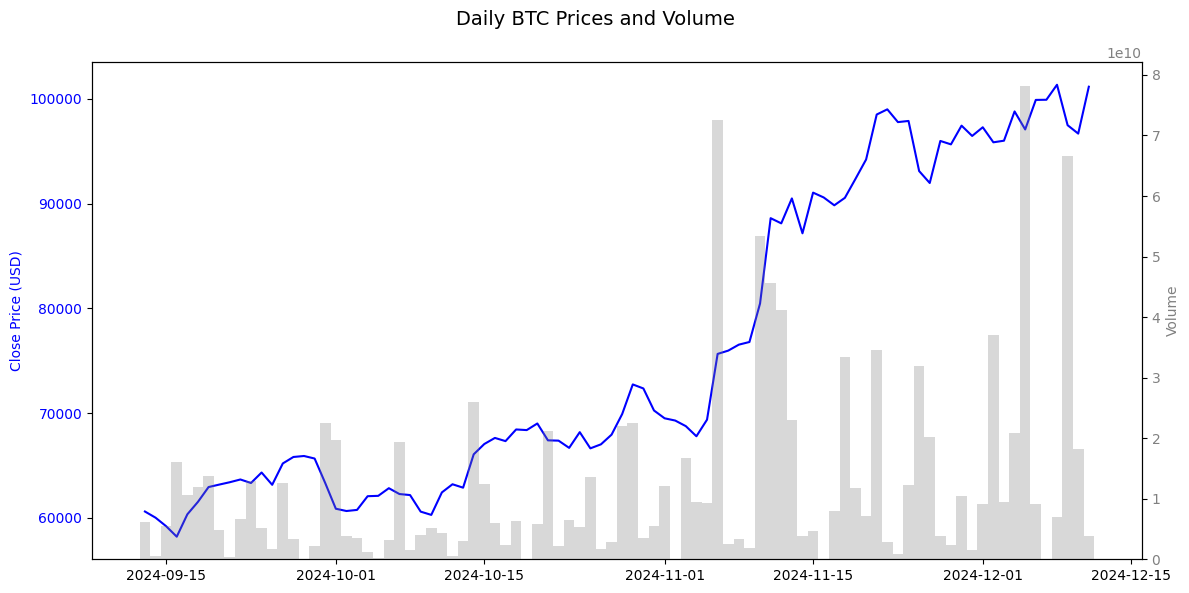

In [4]:
fig, ax1 = plt.subplots(figsize=(12, 6))


ax1.plot(btc_daily.index, btc_daily['Close'], label='Close Price', color='blue')
ax1.set_ylabel('Close Price (USD)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.bar(btc_daily.index, btc_daily['Volume'], label='Volume', color='gray', alpha=0.3, width=1.0)
ax2.set_ylabel('Volume', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

fig.suptitle('Daily BTC Prices and Volume', fontsize=14)
fig.tight_layout()
plt.show()

Le graphique montre les prix de clôture quotidiens du BTC et le volume de trading :

Une volatilité notable est observée dans les prix du BTC au cours des 90 derniers jours.
Les pics de volume coïncident souvent avec des mouvements significatifs des prix, ce qui indique une augmentation de l'activité de trading pendant ces périodes.



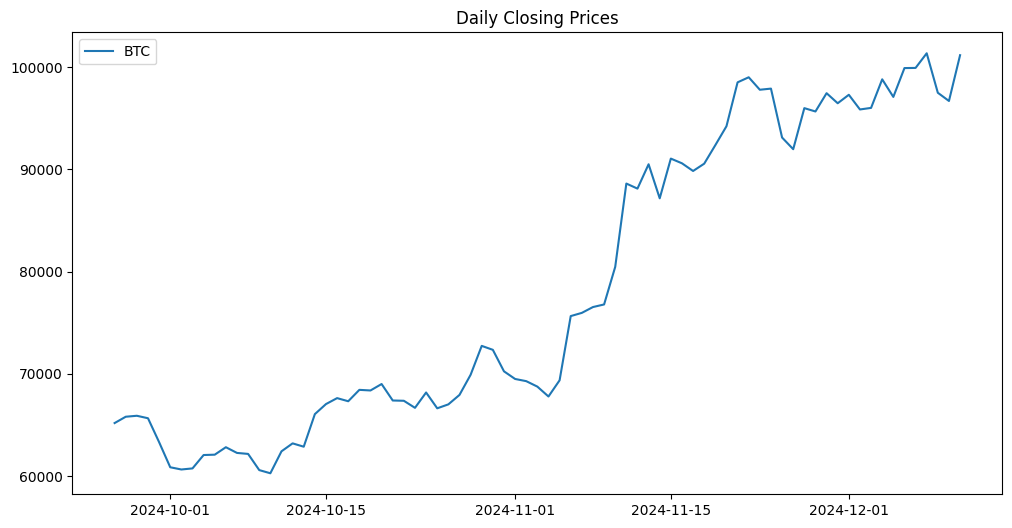

ADF Statistic for BTC Close: 0.029144161672212236
p-value: 0.9608769419793958
BTC Close series is not stationary.


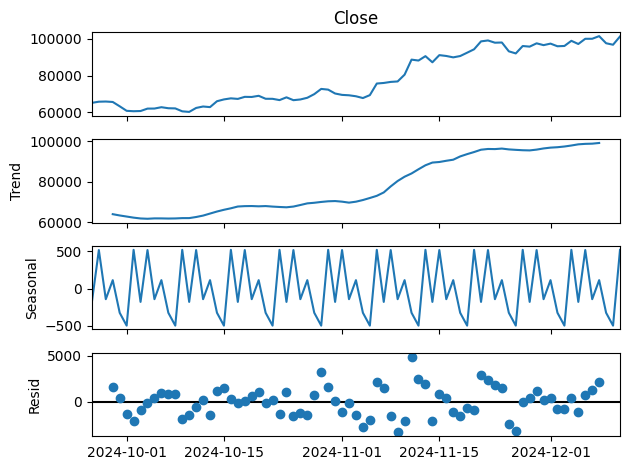

In [34]:
from statsmodels.tsa.stattools import adfuller
plt.figure(figsize=(12, 6))
plt.plot(btc_daily['Close'], label='BTC')
# plt.plot(iota_daily['close'], label='IOTA')
plt.title("Daily Closing Prices")
plt.legend()
plt.show()


def adf_test(series, label):
    result = adfuller(series)
    print(f"ADF Statistic for {label}: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] <= 0.05:
        print(f"{label} series is stationary.")
    else:
        print(f"{label} series is not stationary.")

adf_test(btc_daily['Close'], "BTC Close")


btc_decompose = seasonal_decompose(btc_daily['Close'], model='additive')
btc_decompose.plot()
plt.show()


*******************************************************


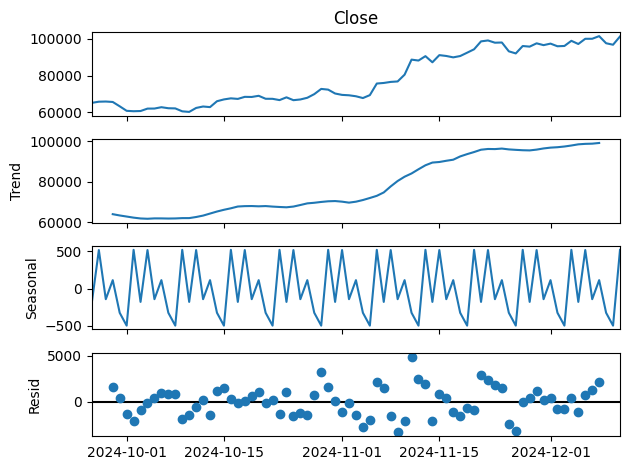

In [35]:

additive_decompose = seasonal_decompose(btc_daily['Close'], model='additive')
additive_decompose.plot()
print("*******************************************************")

multiplicative_decompose = seasonal_decompose(btc_daily['Close'], model='multiplicative')
# multiplicative_decompose.plot()

In [36]:

additive_resid_var = additive_decompose.resid.var()
multiplicative_resid_var = multiplicative_decompose.resid.var()

print("Variance of Additive Residuals:", additive_resid_var)
print("Variance of Multiplicative Residuals:", multiplicative_resid_var)


Variance of Additive Residuals: 2581483.974673026
Variance of Multiplicative Residuals: 0.00041100318201970693


Stationnarité les données


In [37]:

btc_daily['close_diff'] = btc_daily['Close'].diff().dropna()

adf_test(btc_daily['close_diff'].dropna(), "BTC Close (Differenced)")


ADF Statistic for BTC Close (Differenced): -8.149482789239443
p-value: 9.783550629493562e-13
BTC Close (Differenced) series is stationary.


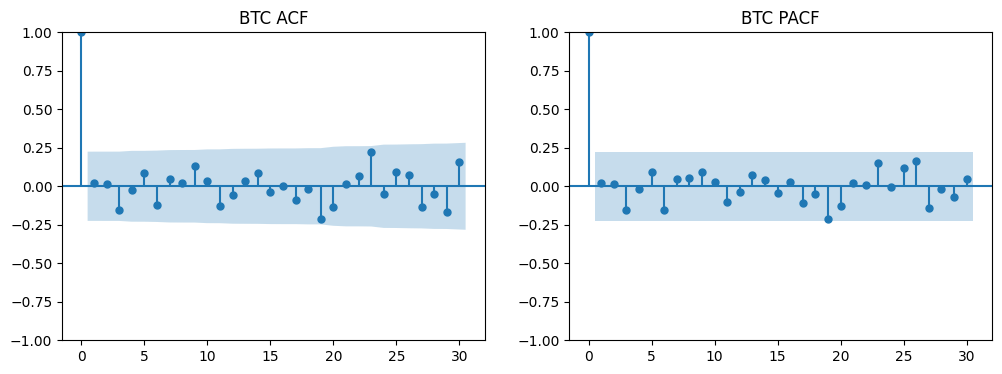

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   77
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -701.670
Date:                Thu, 19 Dec 2024   AIC                           1411.339
Time:                        17:58:45   BIC                           1420.714
Sample:                    09-26-2024   HQIC                          1415.089
                         - 12-11-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.841e+04   2.18e+04      3.593      0.000    3.56e+04    1.21e+05
ar.L1          0.9912      0.021     46.875      0.000       0.950       1.033
ma.L1          0.0605      0.119      0.507      0.6

In [38]:

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(btc_daily['close_diff'].dropna(), ax=axes[0], title='BTC ACF',lags=30)
plot_pacf(btc_daily['close_diff'].dropna(), ax=axes[1], title='BTC PACF',lags=30)
plt.show()


btc_model = ARIMA(btc_daily['Close'], order=(1, 0, 1))
btc_fit = btc_model.fit()

print(btc_fit.summary())

- Étapes suivantes :

1. Ingénierie des fonctionnalités :
Créer des variables retardées (par exemple, le prix du jour précédent) pour aider les modèles à comprendre les patterns séquentiels.

2. Division en ensembles d'entraînement et de test :
Utiliser une division temporelle pour préserver l'ordre chronologique.

3. Test des modèles :
Évaluer des modèles de séries chronologiques traditionnels (ARIMA, SARIMA).
Les comparer avec des modèles d'apprentissage automatique (Random Forest) et des modèles d'apprentissage profond (LSTM).
Commençons par l'ingénierie des fonctionnalités et la préparation du jeu de données pour le modélisation.

In [5]:
btc_daily['MA_7'] = btc_daily['Close'].rolling(window=7).mean()  
btc_daily['MA_14'] = btc_daily['Close'].rolling(window=14).mean() 
btc_daily['Volatility'] = btc_daily['Close'].rolling(window=7).std()

btc_daily['Lag_Close'] = btc_daily['Close'].shift(1)
btc_daily['Daily_Return'] = btc_daily['Close'].pct_change()

btc_daily.dropna(inplace=True)


btc_daily.head()

,Open,High,Low,Close,Adj_Close,Volume,MA_7,MA_14,Volatility,Lag_Close,Daily_Return
Datetime,,,,,,,,,,,
2024-09-26 00:00:00+00:00,63139.601562,65747.742188,62669.269531,65182.535156,65182.535156,12675158016,63738.026228,62065.310826,754.079502,63143.898438,0.032286
2024-09-27 00:00:00+00:00,65179.781250,66453.992188,64854.992188,65801.460938,65801.460938,3410563072,64114.916295,62437.284040,1028.337262,65182.535156,0.009495
2024-09-28 00:00:00+00:00,65789.148438,66229.328125,65464.632812,65895.148438,65895.148438,38201344,64472.847098,62858.047991,1161.267575,65801.460938,0.001424
2024-09-29 00:00:00+00:00,65888.781250,66069.343750,65454.417969,65652.906250,65652.906250,2155432960,64758.596540,63319.780971,1171.858784,65895.148438,-0.003676
2024-09-30 00:00:00+00:00,65613.390625,65613.390625,62931.320312,63312.281250,63312.281250,22464450560,64757.953125,63685.668527,1172.783229,65652.906250,-0.035652


        Random Forest, Linear Regression, XGBoost

In [6]:
features = ['MA_7', 'MA_14', 'Volatility', 'Lag_Close', 'Daily_Return']
target = 'Close'
X = btc_daily[features]
y = btc_daily[target]

splitter = TimeSeriesSplit(n_splits=5)
splits = list(splitter.split(X))


models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Linear Regression': LinearRegression(),
    'XGBoost': XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
}

model_results = {}

for model_name, model in models.items():
    results = []
    for train_idx, test_idx in splits:
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        results.append(rmse)

    model_results[model_name] = np.mean(results)

for model_name, rmse in model_results.items():
    print(f"{model_name}: Average RMSE = {rmse}")


Random Forest: Average RMSE = 5968.654928586822
Linear Regression: Average RMSE = 393.6423101596439
XGBoost: Average RMSE = 6521.910261083793


            ARIMA

In [7]:
def evaluate_arima(train, test, order):
    history = list(train)
    predictions = []
    for t in test:
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(t)
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse

daily_close = btc_daily['Close']
arima_train_size = int(len(daily_close) * 0.7)
arima_train, arima_test = daily_close[:arima_train_size], daily_close[arima_train_size:]

arima_rmse = evaluate_arima(arima_train, arima_test, order=(1, 1, 0))
model_results['ARIMA(1,1,0)'] = arima_rmse
print(f"ARIMA(1, 1, 0): RMSE = {arima_rmse}")

ARIMA(1, 1, 0): RMSE = 2340.9204648018617


        SARIMA

In [8]:
def evaluate_sarima(train, test, order, seasonal_order):
    history = list(train)
    predictions = []
    for t in test:
        model = SARIMAX(history, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        yhat = model_fit.forecast(steps=1)[0]
        predictions.append(yhat)
        history.append(t)
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse

sarima_order = (1, 1, 0) 
seasonal_order = (1, 1, 0, 7) 
sarima_rmse = evaluate_sarima(arima_train, arima_test, sarima_order, seasonal_order)
model_results['SARIMA(1,1,0)(1,1,0,7)'] = sarima_rmse
print(f"SARIMA(1, 1, 0)(1, 1, 0, 7): RMSE = {sarima_rmse}")

SARIMA(1, 1, 0)(1, 1, 0, 7): RMSE = 2957.2988180998527


            LSTM

        LSTM V1

Epoch 1/200
1/1 [==============================] - ETA: 0s - loss: 0.2720
Epoch 1: val_loss improved from inf to 0.31502, saving model to best_lstm_v1_model.h5
1/1 [==============================] - 4s 4s/step - loss: 0.2720 - val_loss: 0.3150
Epoch 2/200
1/1 [==============================] - ETA: 0s - loss: 0.1537
Epoch 2: val_loss improved from 0.31502 to 0.05479, saving model to best_lstm_v1_model.h5


c:\Users\ocp ms\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 104ms/step - loss: 0.1537 - val_loss: 0.0548
Epoch 3/200
1/1 [==============================] - ETA: 0s - loss: 0.0639
Epoch 3: val_loss improved from 0.05479 to 0.04362, saving model to best_lstm_v1_model.h5
1/1 [==============================] - 0s 102ms/step - loss: 0.0639 - val_loss: 0.0436
Epoch 4/200
1/1 [==============================] - ETA: 0s - loss: 0.0139
Epoch 4: val_loss did not improve from 0.04362
1/1 [==============================] - 0s 73ms/step - loss: 0.0139 - val_loss: 0.5580
Epoch 5/200
1/1 [==============================] - ETA: 0s - loss: 0.0513
Epoch 5: val_loss did not improve from 0.04362
1/1 [==============================] - 0s 73ms/step - loss: 0.0513 - val_loss: 0.5185
Epoch 6/200
1/1 [==============================] - ETA: 0s - loss: 0.0515
Epoch 6: val_loss did not improve from 0.04362
1/1 [==============================] - 0s 71ms/step - loss: 0.0515 - val_loss: 0.2338
Epoch 7/200
1/1 [========================

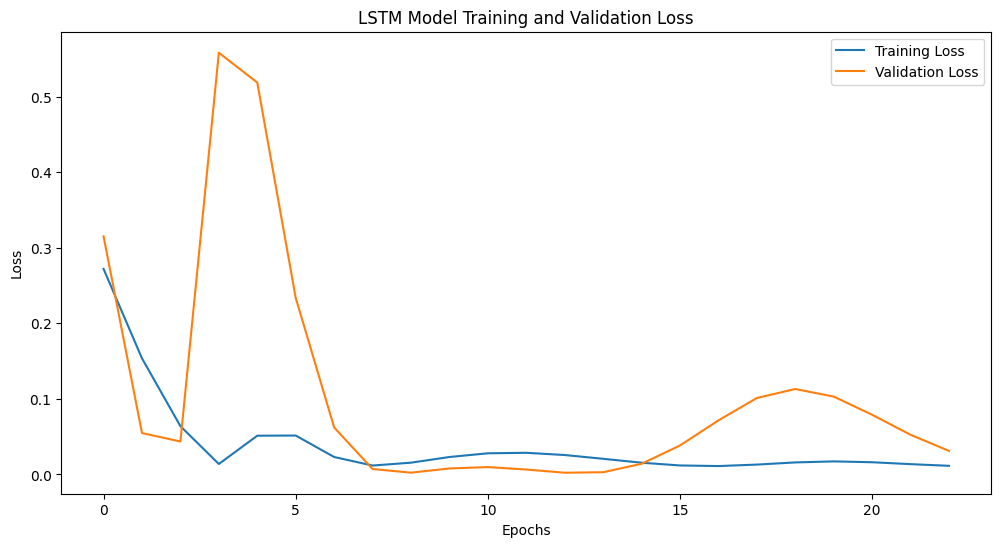

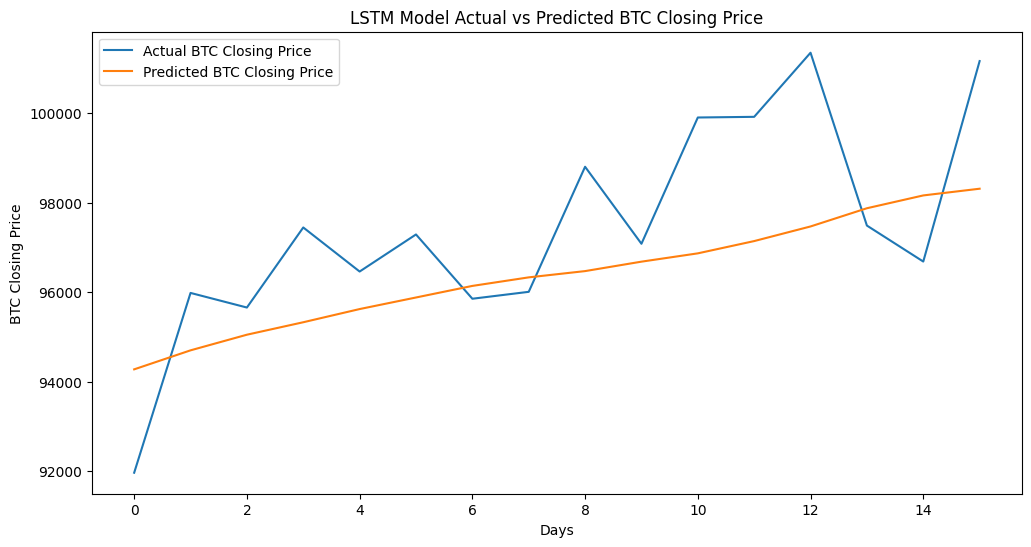

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
daily_close_scaled = scaler.fit_transform(daily_close.values.reshape(-1, 1))

def create_lstm_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 24
lstm_X, lstm_y = create_lstm_dataset(daily_close_scaled, look_back=look_back)

train_size = int(len(lstm_X) * 0.7)
lstm_X_train, lstm_X_test = lstm_X[:train_size], lstm_X[train_size:]
lstm_y_train, lstm_y_test = lstm_y[:train_size], lstm_y[train_size:]


lstm_X_train = lstm_X_train.reshape((lstm_X_train.shape[0], lstm_X_train.shape[1], 1))
lstm_X_test = lstm_X_test.reshape((lstm_X_test.shape[0], lstm_X_test.shape[1], 1))

lstm_model_v1 = Sequential()
lstm_model_v1.add(LSTM(200, return_sequences=True, input_shape=(look_back, 1)))
lstm_model_v1.add(LSTM(100, return_sequences=False))
lstm_model_v1.add(Dense(1))
lstm_model_v1.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

checkpoint_path = "best_lstm_v1_model.h5"  
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',        
    save_best_only=True,       
    save_weights_only=False,   
    mode='min',               
    verbose=1              
)


history = lstm_model_v1.fit(
    lstm_X_train, lstm_y_train,
    epochs=200,
    batch_size=64,
    validation_data=(lstm_X_test, lstm_y_test),
    callbacks=[model_checkpoint, early_stopping],  
    verbose=1
)


best_model = load_model(checkpoint_path)


lstm_y_pred = best_model.predict(lstm_X_test)


lstm_y_pred_rescaled = scaler.inverse_transform(lstm_y_pred)
lstm_y_test_rescaled = scaler.inverse_transform(lstm_y_test.reshape(-1, 1))

lstm_rmse_v1 = np.sqrt(mean_squared_error(lstm_y_test_rescaled, lstm_y_pred_rescaled))
print(f"LSTM: RMSE = {lstm_rmse_v1}")


plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(lstm_y_test_rescaled, label='Actual BTC Closing Price')
plt.plot(lstm_y_pred_rescaled, label='Predicted BTC Closing Price')
plt.title('LSTM Model Actual vs Predicted BTC Closing Price')
plt.xlabel('Days')
plt.ylabel('BTC Closing Price')
plt.legend()
plt.show()

model_results['LSTM_v1'] = lstm_rmse_v1

        LSTM v2

Epoch 1/200
1/1 [==============================] - ETA: 0s - loss: 0.3711
Epoch 1: val_loss improved from inf to 0.45520, saving model to best_lstm_v2_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.3711 - val_loss: 0.4552
Epoch 2/200
1/1 [==============================] - ETA: 0s - loss: 0.2228
Epoch 2: val_loss improved from 0.45520 to 0.16789, saving model to best_lstm_v2_model.h5
1/1 [==============================] - 0s 124ms/step - loss: 0.2228 - val_loss: 0.1679
Epoch 3/200
1/1 [==============================] - ETA: 0s - loss: 0.1273

c:\Users\ocp ms\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_loss improved from 0.16789 to 0.00827, saving model to best_lstm_v2_model.h5
1/1 [==============================] - 0s 118ms/step - loss: 0.1273 - val_loss: 0.0083
Epoch 4/200
1/1 [==============================] - ETA: 0s - loss: 0.0330
Epoch 4: val_loss did not improve from 0.00827
1/1 [==============================] - 0s 75ms/step - loss: 0.0330 - val_loss: 0.0782
Epoch 5/200
1/1 [==============================] - ETA: 0s - loss: 0.0328
Epoch 5: val_loss did not improve from 0.00827
1/1 [==============================] - 0s 73ms/step - loss: 0.0328 - val_loss: 0.2527
Epoch 6/200
1/1 [==============================] - ETA: 0s - loss: 0.0730
Epoch 6: val_loss did not improve from 0.00827
1/1 [==============================] - 0s 81ms/step - loss: 0.0730 - val_loss: 0.2183
Epoch 7/200
1/1 [==============================] - ETA: 0s - loss: 0.0521
Epoch 7: val_loss did not improve from 0.00827
1/1 [==============================] - 0s 81ms/step - loss: 0.0521 - val_loss: 0

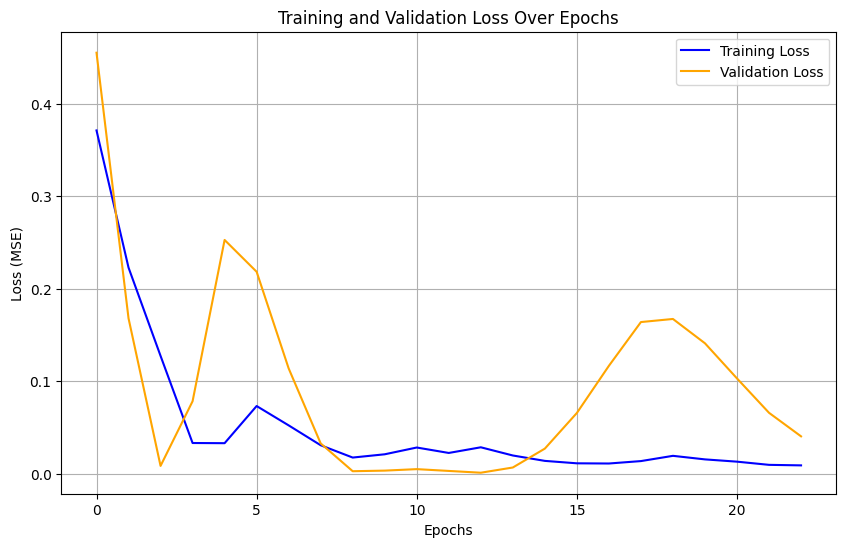

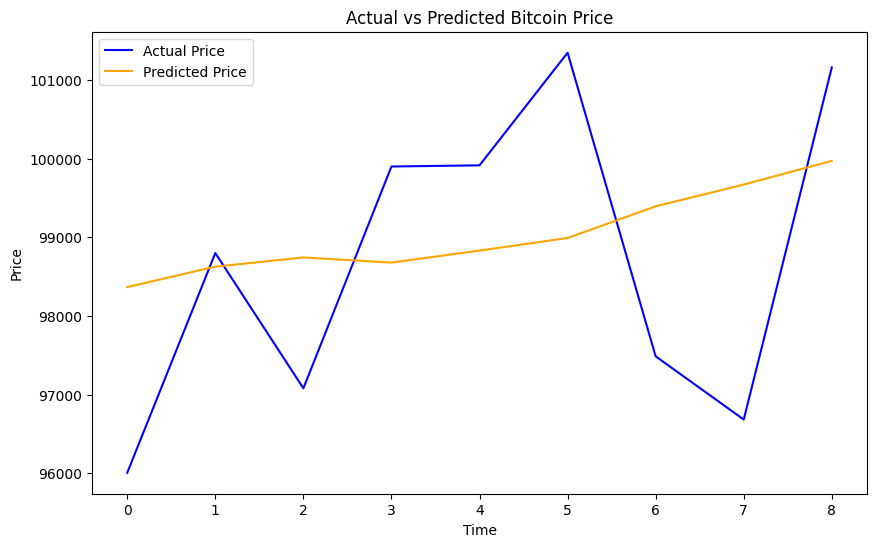

In [11]:
def preprocess_data(data, look_back=24):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    X, y = [], []
    for i in range(len(scaled_data) - look_back):
        X.append(scaled_data[i:i + look_back, :-1])  
        y.append(scaled_data[i + look_back, -1])  
    return np.array(X), np.array(y), scaler

look_back = 24
data = btc_daily[['MA_7', 'MA_14', 'Volatility', 'Lag_Close', 'Daily_Return', 'Close']] 
X, y, scaler = preprocess_data(data.values, look_back)

train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)
X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]


def build_lstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=False)))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1)) 
    model.compile(optimizer='adam', loss='mse')
    return model

LSTM_model = build_lstm_model((X_train.shape[1], X_train.shape[2]))

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint_path = "best_lstm_v2_model.h5"
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)


history = LSTM_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=64,
    callbacks=[model_checkpoint, early_stopping],
    verbose=1
)


best_model_v2 = load_model(checkpoint_path)


y_pred = best_model_v2.predict(X_test)


y_test_actual = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y_test), data.shape[1] - 1)), y_test.reshape(-1, 1)], axis=1)
)[:, -1]
y_pred_actual = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y_pred), data.shape[1] - 1)), y_pred], axis=1)
)[:, -1]


lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mae = mean_absolute_error(y_test_actual, y_pred_actual)

print(f"RMSE: {lstm_rmse}, MAE: {mae}")

model_results['LSTM_v2'] = lstm_rmse

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title("Training and Validation Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual Price', color='blue')
plt.plot(y_pred_actual, label='Predicted Price', color='orange')
plt.title("Actual vs Predicted Bitcoin Price")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

        predictions for tomorrow

In [12]:
def predict_tomorrow(model, data, scaler, look_back=24):
   
    scaled_data = scaler.transform(data)

    last_data = scaled_data[-look_back:, :-1]  
    last_data = np.expand_dims(last_data, axis=0) 

    
    assert last_data.shape == (1, 24, 5), f"Input shape mismatch. Got: {last_data.shape}, Expected: (1, 24, 5)"

    scaled_prediction = model.predict(last_data)[0, 0]

    placeholder = np.zeros((1, data.shape[1]))
    placeholder[0, -1] = scaled_prediction  

    prediction_original_scale = scaler.inverse_transform(placeholder)[0, -1]

    return prediction_original_scale

In [13]:
last_data = data.values[-look_back:, :]

predicted_close = predict_tomorrow(LSTM_model, last_data, scaler, look_back)

print(f"Predicted Close for Tomorrow using LSTM V2: {predicted_close}")

1/1 [==============================] - 1s 1s/step
Predicted Close for Tomorrow using LSTM V2: 100271.99602436925


In [14]:
latest_data = btc_daily.iloc[-1][features].values.reshape(1, -1)
tomorrow_predictions = {}

for model_name, model in models.items():
    tomorrow_predictions[model_name] = model.predict(latest_data)[0]
for model_name, prediction in tomorrow_predictions.items():
    print(f"{model_name}: Predicted price for tomorrow = {prediction}")


Random Forest: Predicted price for tomorrow = 96051.612265625
Linear Regression: Predicted price for tomorrow = 100280.49567507413
XGBoost: Predicted price for tomorrow = 94266.7890625


c:\Users\ocp ms\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\ocp ms\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


        Best model

In [15]:
print("Model Performance (RMSE):")
for model_name, rmse_value in model_results.items():
    print(f"{model_name}: {rmse_value}")

best_model = min(model_results, key=model_results.get)
print(f"\nBest Model: {best_model} with RMSE = {model_results[best_model]}")


Model Performance (RMSE):
Random Forest: 5968.654928586822
Linear Regression: 393.6423101596439
XGBoost: 6521.910261083793
ARIMA(1,1,0): 2340.9204648018617
SARIMA(1,1,0)(1,1,0,7): 2957.2988180998527
ExponentialSmoothing: 2339.4135640583336
LSTM_v1: 1979.9627231518296
LSTM_v2: 1843.1959405323516

Best Model: Linear Regression with RMSE = 393.6423101596439


        True hourly closing price for the next day

In [16]:
last_date = btc_daily.index[-1]

next_day = last_date + pd.Timedelta(days=1)
print(f"Next day for prediction: {next_day}")


Next day for prediction: 2024-12-12 00:00:00+00:00


In [17]:
btc = yf.Ticker("BTC-USD")
btc_hourly_data = btc.history(start=next_day, end=next_day + pd.Timedelta(days=1), interval="1h")

true_close_next_day = btc_hourly_data['Close'].iloc[-1]
print(f"True hourly closing price for the next day: {true_close_next_day}")

True hourly closing price for the next day: 100057.328125


CNN 


Epoch 1: val_loss improved from inf to 0.12947, saving model to best_cnn_model.h5

Epoch 2: val_loss improved from 0.12947 to 0.05755, saving model to best_cnn_model.h5

Epoch 3: val_loss improved from 0.05755 to 0.02691, saving model to best_cnn_model.h5

Epoch 4: val_loss improved from 0.02691 to 0.01750, saving model to best_cnn_model.h5


c:\Users\ocp ms\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 5: val_loss improved from 0.01750 to 0.01637, saving model to best_cnn_model.h5

Epoch 6: val_loss did not improve from 0.01637

Epoch 7: val_loss did not improve from 0.01637

Epoch 8: val_loss did not improve from 0.01637

Epoch 9: val_loss did not improve from 0.01637

Epoch 10: val_loss did not improve from 0.01637

Epoch 11: val_loss did not improve from 0.01637

Epoch 12: val_loss did not improve from 0.01637

Epoch 13: val_loss did not improve from 0.01637

Epoch 14: val_loss did not improve from 0.01637

Epoch 15: val_loss did not improve from 0.01637
1/1 [==============================] - 0s 55ms/step

Epoch 1: val_loss did not improve from 0.01637

Epoch 2: val_loss did not improve from 0.01637

Epoch 3: val_loss did not improve from 0.01637

Epoch 4: val_loss did not improve from 0.01637

Epoch 5: val_loss did not improve from 0.01637

Epoch 6: val_loss did not improve from 0.01637

Epoch 7: val_loss did not improve from 0.01637

Epoch 8: val_loss did not improve from

c:\Users\ocp ms\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 21: val_loss did not improve from 0.01426

Epoch 22: val_loss did not improve from 0.01426

Epoch 23: val_loss did not improve from 0.01426

Epoch 24: val_loss did not improve from 0.01426

Epoch 25: val_loss did not improve from 0.01426

Epoch 26: val_loss did not improve from 0.01426
1/1 [==============================] - 0s 19ms/step

Epoch 1: val_loss did not improve from 0.01426

Epoch 2: val_loss did not improve from 0.01426

Epoch 3: val_loss did not improve from 0.01426

Epoch 4: val_loss did not improve from 0.01426

Epoch 5: val_loss did not improve from 0.01426

Epoch 6: val_loss did not improve from 0.01426

Epoch 7: val_loss did not improve from 0.01426

Epoch 8: val_loss did not improve from 0.01426

Epoch 9: val_loss did not improve from 0.01426

Epoch 10: val_loss did not improve from 0.01426

Epoch 11: val_loss did not improve from 0.01426

Epoch 12: val_loss did not improve from 0.01426

Epoch 13: val_loss did not improve from 0.01426

Epoch 14: val_loss did no

c:\Users\ocp ms\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 8: val_loss did not improve from 0.00064

Epoch 9: val_loss did not improve from 0.00064

Epoch 10: val_loss did not improve from 0.00064

Epoch 11: val_loss did not improve from 0.00064

Epoch 12: val_loss did not improve from 0.00064

Epoch 13: val_loss did not improve from 0.00064
1/1 [==============================] - 0s 21ms/step

Epoch 1: val_loss did not improve from 0.00064

Epoch 2: val_loss did not improve from 0.00064

Epoch 3: val_loss did not improve from 0.00064

Epoch 4: val_loss did not improve from 0.00064

Epoch 5: val_loss did not improve from 0.00064

Epoch 6: val_loss did not improve from 0.00064

Epoch 7: val_loss did not improve from 0.00064

Epoch 8: val_loss did not improve from 0.00064

Epoch 9: val_loss did not improve from 0.00064

Epoch 10: val_loss did not improve from 0.00064

Epoch 11: val_loss did not improve from 0.00064

Epoch 12: val_loss did not improve from 0.00064

Epoch 13: val_loss did not improve from 0.00064

Epoch 14: val_loss did not 

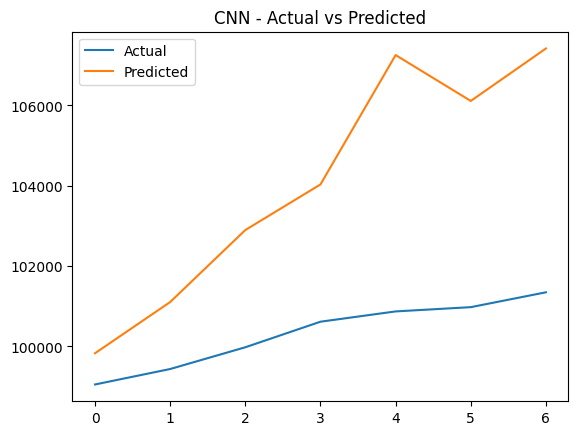

In [18]:
features = ['MA_7', 'MA_14', 'Volatility', 'Lag_Close', 'Daily_Return']
target = 'Close'
X = btc_daily[features]
y = btc_daily[target]

scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

def create_cnn_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), :]) 
        y.append(data[i + look_back, 0]) 
    return np.array(X), np.array(y)

look_back = 30
X_cnn, y_cnn = create_cnn_dataset(X_scaled, look_back)

splitter = TimeSeriesSplit(n_splits=5)
splits = list(splitter.split(X_cnn))

cnn_model = Sequential()
cnn_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(look_back, X_cnn.shape[2])))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(50, activation='relu'))
cnn_model.add(Dropout(0.2)) 
cnn_model.add(Dense(1))

cnn_model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_cnn_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

cnn_results = []
for train_idx, test_idx in splits:
    X_train, X_test = X_cnn[train_idx], X_cnn[test_idx]
    y_train, y_test = y_cnn[train_idx], y_cnn[test_idx]

    cnn_model.fit(X_train, y_train, epochs=100, batch_size=64, 
                  validation_data=(X_test, y_test), verbose=0, 
                  callbacks=[early_stopping, checkpoint])

    cnn_model.load_weights('best_cnn_model.h5')

    
    y_pred = cnn_model.predict(X_test)
    

    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))


    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    cnn_results.append(rmse)


model_results['CNN'] = np.mean(cnn_results)


for model_name, rmse in model_results.items():
    print(f"{model_name}: Average RMSE = {rmse}")

plt.plot(np.arange(len(y_test_rescaled)), y_test_rescaled, label='Actual')
plt.plot(np.arange(len(y_pred_rescaled)), y_pred_rescaled, label='Predicted')
plt.title(f"CNN - Actual vs Predicted")
plt.legend()
plt.show()

        CNN + LSTM


Epoch 1: val_loss improved from inf to 0.09050, saving model to best_cnn_lstm_model.h5

Epoch 2: val_loss improved from 0.09050 to 0.06054, saving model to best_cnn_lstm_model.h5

Epoch 3: val_loss improved from 0.06054 to 0.03857, saving model to best_cnn_lstm_model.h5

Epoch 4: val_loss improved from 0.03857 to 0.02321, saving model to best_cnn_lstm_model.h5


c:\Users\ocp ms\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 5: val_loss improved from 0.02321 to 0.01151, saving model to best_cnn_lstm_model.h5

Epoch 6: val_loss improved from 0.01151 to 0.00537, saving model to best_cnn_lstm_model.h5

Epoch 7: val_loss improved from 0.00537 to 0.00376, saving model to best_cnn_lstm_model.h5

Epoch 8: val_loss improved from 0.00376 to 0.00335, saving model to best_cnn_lstm_model.h5

Epoch 9: val_loss did not improve from 0.00335

Epoch 10: val_loss did not improve from 0.00335

Epoch 11: val_loss did not improve from 0.00335

Epoch 12: val_loss did not improve from 0.00335

Epoch 13: val_loss did not improve from 0.00335

Epoch 14: val_loss did not improve from 0.00335

Epoch 15: val_loss did not improve from 0.00335

Epoch 16: val_loss did not improve from 0.00335

Epoch 17: val_loss did not improve from 0.00335

Epoch 18: val_loss did not improve from 0.00335
1/1 [==============================] - 0s 355ms/step

Epoch 1: val_loss did not improve from 0.00335

Epoch 2: val_loss did not improve from 0.

c:\Users\ocp ms\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 9: val_loss did not improve from 0.00034

Epoch 10: val_loss did not improve from 0.00034

Epoch 11: val_loss did not improve from 0.00034

Epoch 12: val_loss did not improve from 0.00034

Epoch 13: val_loss did not improve from 0.00034

Epoch 14: val_loss did not improve from 0.00034

Epoch 15: val_loss did not improve from 0.00034

Epoch 16: val_loss did not improve from 0.00034
1/1 [==============================] - 0s 20ms/step

Epoch 1: val_loss did not improve from 0.00034

Epoch 2: val_loss did not improve from 0.00034

Epoch 3: val_loss did not improve from 0.00034

Epoch 4: val_loss did not improve from 0.00034

Epoch 5: val_loss did not improve from 0.00034

Epoch 6: val_loss did not improve from 0.00034

Epoch 7: val_loss did not improve from 0.00034

Epoch 8: val_loss did not improve from 0.00034

Epoch 9: val_loss did not improve from 0.00034

Epoch 10: val_loss improved from 0.00034 to 0.00026, saving model to best_cnn_lstm_model.h5

Epoch 11: val_loss did not impr

c:\Users\ocp ms\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 15: val_loss did not improve from 0.00021

Epoch 16: val_loss did not improve from 0.00021

Epoch 17: val_loss did not improve from 0.00021

Epoch 18: val_loss did not improve from 0.00021

Epoch 19: val_loss did not improve from 0.00021

Epoch 20: val_loss did not improve from 0.00021

Epoch 21: val_loss did not improve from 0.00021

Epoch 22: val_loss did not improve from 0.00021

Epoch 23: val_loss did not improve from 0.00021

Epoch 24: val_loss did not improve from 0.00021
1/1 [==============================] - 0s 19ms/step
Random Forest: Average RMSE = 5968.654928586822
Linear Regression: Average RMSE = 393.6423101596439
XGBoost: Average RMSE = 6521.910261083793
ARIMA(1,1,0): Average RMSE = 2340.9204648018617
SARIMA(1,1,0)(1,1,0,7): Average RMSE = 2957.2988180998527
ExponentialSmoothing: Average RMSE = 2339.4135640583336
LSTM_v1: Average RMSE = 1979.9627231518296
LSTM_v2: Average RMSE = 1843.1959405323516
CNN: Average RMSE = 5404.978035430936
CNN_LSTM_v1: Average RMSE = 53

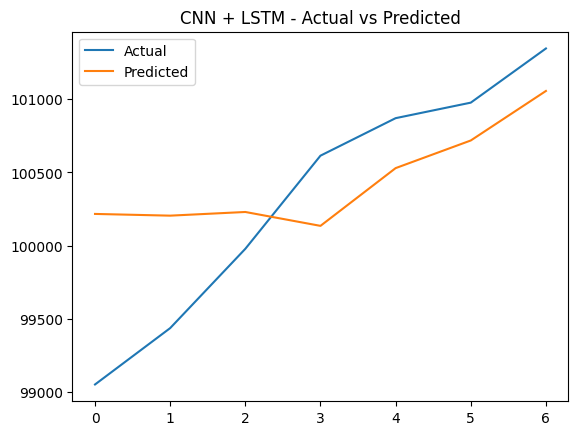

In [19]:
features = ['MA_7', 'MA_14', 'Volatility', 'Lag_Close', 'Daily_Return']
target = 'Close'
X = btc_daily[features]
y = btc_daily[target]

scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

def create_cnn_lstm_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), :]) 
        y.append(data[i + look_back, 0]) 
    return np.array(X), np.array(y)

look_back = 30
X_cnn_lstm, y_cnn_lstm = create_cnn_lstm_dataset(X_scaled, look_back)

splitter = TimeSeriesSplit(n_splits=5)
splits = list(splitter.split(X_cnn_lstm))

cnn_lstm_model = Sequential()
cnn_lstm_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(look_back, X_cnn_lstm.shape[2])))
cnn_lstm_model.add(MaxPooling1D(pool_size=2))
cnn_lstm_model.add(LSTM(50, return_sequences=False))

cnn_lstm_model.add(Dense(50, activation='relu'))
cnn_lstm_model.add(Dropout(0.2)) 
cnn_lstm_model.add(Dense(1)) 

cnn_lstm_model.compile(optimizer='adam', loss='mean_squared_error')


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_cnn_lstm_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)




cnn_lstm_results = []
for train_idx, test_idx in splits:
    X_train, X_test = X_cnn_lstm[train_idx], X_cnn_lstm[test_idx]
    y_train, y_test = y_cnn_lstm[train_idx], y_cnn_lstm[test_idx]

    cnn_lstm_model.fit(X_train, y_train, epochs=100, batch_size=64, 
                       validation_data=(X_test, y_test), verbose=0, 
                       callbacks=[early_stopping, checkpoint])

   
    cnn_lstm_model.load_weights('best_cnn_lstm_model.h5')

  
    y_pred = cnn_lstm_model.predict(X_test)
 
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    cnn_lstm_results.append(rmse)


model_results['CNN_LSTM_v1'] = np.mean(cnn_lstm_results)


for model_name, rmse in model_results.items():
    print(f"{model_name}: Average RMSE = {rmse}")

plt.plot(np.arange(len(y_test_rescaled)), y_test_rescaled, label='Actual')
plt.plot(np.arange(len(y_pred_rescaled)), y_pred_rescaled, label='Predicted')
plt.title(f"CNN + LSTM - Actual vs Predicted")
plt.legend()
plt.show()


In [21]:
last_30_days = btc_daily['Close'].values[-look_back:]

last_30_days_scaled = scaler.transform(last_30_days.reshape(-1, 1))

last_30_days_scaled = last_30_days_scaled.reshape((1, look_back, 1))  # (1, 30, 1)

predicted_price_scaled = cnn_lstm_model.predict(last_30_days_scaled)


predicted_price = scaler.inverse_transform(predicted_price_scaled)

print(f"Predicted Closing Price for Tomorrow using CNN + LSTM MODEL: {predicted_price[0][0]}")

1/1 [==============================] - 0s 20ms/step
Predicted Closing Price for Tomorrow using CNN + LSTM MODEL: 100545.7265625
